In [1]:
#needed after restructuring of directory
import os
os.chdir('/Users/alexchandler/UFC_Prediction_2022')
os.getcwd()

'/Users/alexchandler/UFC_Prediction_2022'

In [2]:
#getting dependencies
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' (disables SettingWithCopyWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import random
import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools
#this imports all of the functions from the file functions.py
os.chdir('/Users/alexchandler/UFC_Prediction_2022/src')
from functions import *
os.chdir('/Users/alexchandler/UFC_Prediction_2022')#importing csv fight data and saving as dataframes
ufc_fights_winner = pd.read_csv('src/models/buildingMLModel/data/processed/ufc_fights.csv',low_memory=False)

In [3]:
#there are some issues with how names are saved
#it gets saved as Joanne Wood for some reason
for i in range(len(ufc_fights_winner['fighter'])):
    if ufc_fights_winner['fighter'][i]=='Joanne Wood':
        ufc_fights_winner['fighter'][i]='Joanne Calderwood'
    if ufc_fights_winner['opponent'][i]=='Joanne Wood':
        ufc_fights_winner['opponent'][i]='Joanne Calderwood'

In [4]:
#assumes first and last name
def swap_name(name):
    first_name=''
    last_name=''
    for i in range(len(name)):
        if name[i]==' ':
            first_name += name[0:i]
            last_name += name[i+1:]
            break
    return last_name+' '+first_name

swap_name('Xiaonan Yan')

'Yan Xiaonan'

In [5]:
#this finds all names in ufcfightscrap which are sometimes written in the wrong order 
#e.g. ('Weili Zhang', 'Zhang Weili')
names = [name for name in ufcfightscrap['fighter']]
opponent_names = [name for name in ufcfightscrap['opponent']]
names.extend(opponent_names)
names_swapped = [swap_name(name) for name in names]
errors=[name for name in names if name in names_swapped]
names_to_fix = list(set(errors))
pairs = [[name,swap_name(name)] for name in names_to_fix]
sorted_pairs = []
for pair in pairs:
    pair.sort()
    sorted_pairs.append(tuple(pair))
error_pairs = list(set(sorted_pairs))
error_pairs

[]

In [6]:
#fixing all swapped names
#setting name so that first name is before last name in lex order
for i in range(len(ufcfightscrap['fighter'])):
    for pair in error_pairs:
        if ufcfightscrap['fighter'][i]==pair[0] or ufcfightscrap['fighter'][i]==pair[1]:
            ufcfightscrap['fighter'][i]=pair[0] 
        if ufcfightscrap['opponent'][i]==pair[0] or ufcfightscrap['opponent'][i]==pair[1]:
            ufcfightscrap['opponent'][i]=pair[0] 

In [7]:
#checking that we've fixed all of the errors
names = [name for name in ufcfightscrap['fighter']]
opponent_names = [name for name in ufcfightscrap['opponent']]
names.extend(opponent_names)
names_swapped = [swap_name(name) for name in names]
errors=[name for name in names if name in names_swapped]
names_to_fix = list(set(errors))
pairs = [[name,swap_name(name)] for name in names_to_fix]
sorted_pairs = []
for pair in pairs:
    pair.sort()
    sorted_pairs.append(tuple(pair))
error_pairs = list(set(sorted_pairs))
error_pairs

[]

In [8]:
#scores a model
def model_score(dataframe,features, iloc_val = 3200, _max_iter = 2000):
    yyy=dataframe['result'].iloc[0:iloc_val]
    XXX=dataframe[features].iloc[0:iloc_val]
    XXXscaler = preprocessing.StandardScaler().fit(XXX)
    XXX_scaled = XXXscaler.transform(XXX) 
    winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=_max_iter)
    return cross_val_score(winPredictionModel,XXX_scaled,yyy,cv=4).mean()
    
#CODE FOR THE GREEDY ALGORITHM FOR FEATURE SELECTION
def greedy(dataframe, features, subsetsize, iloc_val=3200, _max_iter = 2000):
    i=0
    best_stats=[]
    s=set(features)
    subsets=list(map(set, itertools.combinations(s, subsetsize))) #subsets of size (subsetsize)
    possible_stat_dict = {}
    scores={0:0}
    for stat_pair in subsets:
        possible_stat_dict[tuple(stat_pair)]=0
    while (i==0) or (scores[i]>scores[i-1]):
        i+=1
        for stat_pair in list(possible_stat_dict.keys()):
            stats_temp = best_stats+list(stat_pair)
            possible_stat_dict[tuple(stat_pair)]=model_score(ufc_fights_winner,stats_temp,iloc_val,_max_iter)
        max_key = max(possible_stat_dict, key=possible_stat_dict.get)
        best_stats.extend(list(max_key))
        scores[i]=possible_stat_dict[max_key]
        possible_stat_dict.pop(max_key)
        print(best_stats,scores[i])
    return (best_stats[:-subsetsize], scores[i-1])

In [9]:
# cleans method column so 'M-DEC' and 'U-DEC' count as decision, 
# and 'S-DEC', 'doctor stoppage', 'overturned' etc counts as 'bullshit'
ufc_fights_winner['method'] = clean_method_for_winner_vect(ufc_fights_winner['method'])
ufc_fights_winner['method'].unique()

array(['KO/TKO', 'bullshit', 'DEC', 'SUB'], dtype=object)

In [10]:
#adding stance 
ufc_fights['fighter_stance']=stance_vect(ufc_fights['fighter'])
ufc_fights['opponent_stance']=stance_vect(ufc_fights['opponent'])

In [54]:
#WHY AM I USING u'' i.e. unicode... r'' takes less memory space. Was there a reason for using u?
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights_winner['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no split decision or DQ or Overturned or anything else like that)
method_mask_winner=(ufc_fights_winner['method']!='bullshit')
#fights where age is known
age_mask=(ufc_fights_winner['fighter_age']!='unknown')&(ufc_fights_winner['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights_winner['fighter_height']!='unknown')&(ufc_fights_winner['opponent_height']!='unknown')
reach_mask=(ufc_fights_winner['fighter_reach']!='unknown')&(ufc_fights_winner['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights_winner['fighter_wins'] != 'unknown' )& (ufc_fights_winner['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights_winner['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights_winner['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights_winner=ufc_fights_winner[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

#listing all stats and making some new stats from them (differences often score higher in the learning models)
record_statistics=[u'fighter_wins', u'fighter_losses', u'fighter_L5Y_wins',u'fighter_L5Y_losses', 
                   u'fighter_L2Y_wins', u'fighter_L2Y_losses',u'fighter_ko_wins',u'fighter_ko_losses',
                   u'fighter_L5Y_ko_wins',u'fighter_L5Y_ko_losses',u'fighter_L2Y_ko_wins',u'fighter_L2Y_ko_losses',
                   u'fighter_sub_wins',u'fighter_sub_losses',u'fighter_L5Y_sub_wins',u'fighter_L5Y_sub_losses', 
                   u'fighter_L2Y_sub_wins', u'fighter_L2Y_sub_losses',u'opponent_wins', u'opponent_losses',
                   u'opponent_L5Y_wins', 
                   u'opponent_L5Y_losses', 
                   u'opponent_L2Y_wins', 
                   u'opponent_L2Y_losses', 
                    u'opponent_ko_wins', 
                   u'opponent_ko_losses', 
                   u'opponent_L5Y_ko_wins', 
                   u'opponent_L5Y_ko_losses', 
                   u'opponent_L2Y_ko_wins',
                    u'opponent_L2Y_ko_losses', 
                   u'opponent_sub_wins', 
                   u'opponent_sub_losses',
                   u'opponent_L5Y_sub_wins', 
                    u'opponent_L5Y_sub_losses', 
                   u'opponent_L2Y_sub_wins', 
                   u'opponent_L2Y_sub_losses']

physical_stats=[ u'fighter_age',
                u'fighter_height',
                    u'fighter_reach',  
                u'opponent_age',  
                u'opponent_height',
                    u'opponent_reach']

#THERE MAY BE A PROBLEM IN AGE HEIGHT REACH TO DO WITH STRING VS FLOAT. MAKE SURE THESE ARE ALL THE CORRECT TYPE
#MAYBE WE ARE LOSING PREDICTABILITY HERE

#here is the list of all stats available (besides stance), does not include names or result
punch_statistics=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                    
                    u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg']


#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[record_statistics[i]+'_diff_2']=ufc_fights_winner[record_statistics[i]]-ufc_fights_winner[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights_winner['height_diff']=ufc_fights_winner['fighter_height'].apply(float)-ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['reach_diff']=ufc_fights_winner['fighter_reach'].apply(float)-ufc_fights_winner['opponent_reach'].apply(float)

physical_stats_diff = ['fighter_age_diff', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights (inf-inf abs-abs)
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[punch_statistics[i]+'_diff_2']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
#adding other style of punch differences to ufc_fights (inf-abs abs-inf)
punch_statistics_diff_alt=[]
quarter_length=int(len(punch_statistics)/4)
for i in range(quarter_length):
    ufc_fights_winner[punch_statistics[i]+'_diff_2_alt']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+3*quarter_length]]
    punch_statistics_diff_alt.append(punch_statistics[i]+'_diff_2_alt')
for i in range(quarter_length,2*quarter_length):
    ufc_fights_winner[punch_statistics[i]+'_diff_2_alt']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+quarter_length]]
    punch_statistics_diff_alt.append(punch_statistics[i]+'_diff_2_alt')
    
    
    
fight_math_stats=['4-fighter_score_diff',
 '9-fighter_score_diff',
 '15-fighter_score_diff',
 '1-fight_math',
 '6-fight_math']
    
possible_stats_diff =record_statistics_diff+physical_stats_diff+punch_statistics_diff+punch_statistics_diff_alt+fight_math_stats
possible_stats_all = possible_stats_diff+record_statistics+physical_stats+punch_statistics


In [35]:
ufc_fights_winner['result'].unique()

array(['W', 'L'], dtype=object)

In [36]:
ufc_fights_winner['method'].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

In [37]:
#changing columns saved as strings to floats
ufc_fights_winner['fighter_age'] = ufc_fights_winner['fighter_age'].apply(float)
ufc_fights_winner['fighter_height'] = ufc_fights_winner['fighter_height'].apply(float)
ufc_fights_winner['fighter_reach'] = ufc_fights_winner['fighter_reach'].apply(float)
ufc_fights_winner['opponent_age'] = ufc_fights_winner['opponent_age'].apply(float)
ufc_fights_winner['opponent_height'] = ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['opponent_reach'] = ufc_fights_winner['opponent_reach'].apply(float)
ufc_fights_winner['fighter_stance'] = ufc_fights_winner['fighter_stance'].apply(float)
ufc_fights_winner['opponent_stance'] = ufc_fights_winner['opponent_stance'].apply(float)

In [38]:
#picking a model
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=1000)

In [39]:
#adding an age_diff column 
#lets make this a function which measures something more precise, 
#like the difference in how close the fighters are to being prime fighting age
#prime fighting age
ufc_fights_winner['fighter_age_diff'] = ufc_fights_winner['fighter_age']-ufc_fights_winner['opponent_age']


In [55]:
ufc_fights_winner.dtypes

date                                                     object
division                                                 object
fighter                                                  object
opponent                                                 object
result                                                   object
method                                                   object
fighter_wins                                            float64
fighter_losses                                          float64
fighter_age                                             float64
fighter_height                                          float64
fighter_reach                                           float64
fighter_L5Y_wins                                        float64
fighter_L5Y_losses                                      float64
fighter_L2Y_wins                                        float64
fighter_L2Y_losses                                      float64
fighter_ko_wins                         

In [56]:
# LR model score with just record statistics considered
model_score(ufc_fights_winner,record_statistics)

0.56625

In [57]:
# LR model score with just record statistics differences considered (higher)
model_score(ufc_fights_winner,record_statistics_diff)

0.5659375

In [58]:
# LR model score with just physical statistics considered
model_score(ufc_fights_winner,physical_stats)

0.5809375

In [59]:
# LR model score with just physical statistics differences considered (lower... but not too much)
model_score(ufc_fights_winner,physical_stats_diff)

0.5831250000000001

In [60]:
# LR model score with just punch statistics considered
model_score(ufc_fights_winner,punch_statistics)

0.5821875000000001

In [61]:
# LR model score with just punch statistics differences considered (higher)
model_score(ufc_fights_winner,punch_statistics_diff)

0.576875

In [62]:
# LR model score with just punch statistics differences considered (higher)
model_score(ufc_fights_winner,punch_statistics_diff_alt)

0.5503125

In [63]:
# LR model score with just punch statistics differences considered (higher)
model_score(ufc_fights_winner,punch_statistics_diff+punch_statistics_diff_alt)

0.5784374999999999

In [66]:
#score just from fight math
model_score(ufc_fights_winner,fight_math_stats)

0.583125

In [65]:
#model score with all possible stats (absolute and differences) (slightly lower)
model_score(ufc_fights_winner,possible_stats_all)

0.6068749999999999

In [64]:
#model score with all possible stats (only differences)
model_score(ufc_fights_winner,possible_stats_diff)

0.6162500000000001

1 0.45
2 0.36250000000000004
3 0.55
4 0.6125
5 0.6050000000000001
6 0.5791666666666667
7 0.5785714285714286
8 0.6156250000000001
9 0.6
10 0.6075
11 0.6022727272727273
12 0.6125
13 0.6134615384615385
14 0.6035714285714285
15 0.615
16 0.5890624999999999
17 0.6014705882352942
18 0.5888888888888889
19 0.5710526315789473
20 0.58125
21 0.5797619047619048
22 0.5874999999999999
23 0.5945652173913043
24 0.6041666666666667
25 0.608
26 0.6000000000000001
27 0.5972222222222222
28 0.5839285714285715
29 0.5844827586206898
30 0.5858333333333334
31 0.5838709677419355
32 0.59375
33 0.5871212121212122
34 0.5933823529411765
35 0.5950000000000001
36 0.5861111111111111
37 0.5905405405405405
38 0.5855263157894737
39 0.6006410256410256
40 0.605625
41 0.6018292682926829
42 0.5922619047619049
43 0.5959302325581395
44 0.6005681818181818
45 0.6033333333333333
46 0.592391304347826
47 0.598936170212766
48 0.6036458333333334
49 0.5989795918367347
50 0.6005
51 0.6063725490196079
52 0.5985576923076923
53 0.6061320754

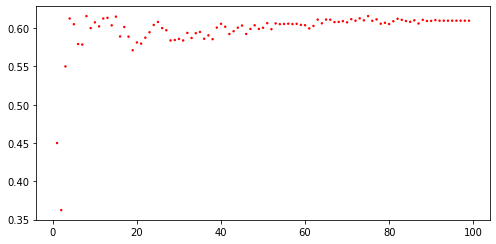

In [27]:
#lets see the best number of examples to use. Looks like 40*75
from sklearn.feature_selection import SelectKBest, chi2
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff
xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights_winner,possible_stats,40*i))
    yy.append(model_score(ufc_fights_winner,possible_stats,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [26]:
ufc_fights_winner['fighter_age'].unique()

array([33., 27., 37., 28., 29., 31., 30., 32., 26., 35., 40., 38., 24.,
       34., 25., 36., 39., 23., 42., 43., 41., 21., 22., 20., 44., 46.,
       19., 45., 47.])

In [68]:
# adds one stat at a time, always choosing the one that increases score by the most (greedy)
# best so far at .629 (4/16 improved to .639 after fixing fight math and fight score)
greedy(ufc_fights_winner, possible_stats_diff, 1,40*75)

['fighter_age_diff'] 0.5813333333333333
['fighter_age_diff', '4-fighter_score_diff'] 0.616
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2'] 0.6326666666666666
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt'] 0.635
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt', '1-fight_math'] 0.6366666666666667
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt', '1-fight_math', 'fighter_inf_distance_strikes_landed_avg_diff_2'] 0.6383333333333334
['fighter_age_diff', '4-fighter_score_diff', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt', '1-fight_math', 'fighter_inf_distance_strikes_landed_avg_diff_2', 'fighter_L2Y_sub_losses_diff_2'] 0

(['fighter_age_diff',
  '4-fighter_score_diff',
  'fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_abs_leg_strikes_attempts_avg_diff_2_alt',
  '1-fight_math',
  'fighter_inf_distance_strikes_landed_avg_diff_2',
  'fighter_L2Y_sub_losses_diff_2',
  'fighter_abs_total_strikes_attempts_avg_diff_2_alt'],
 0.6396666666666666)

In [ ]:
# adds two stats at a time, always choosing the two that increases score by the most (greedy)
# best so far at .629 (4/16 improved to .639 after fixing fight math and fight score)
greedy(ufc_fights_winner, possible_stats_diff, 2,40*75)

['4-fighter_score_diff', 'fighter_age_diff'] 0.616
['4-fighter_score_diff', 'fighter_age_diff', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt', 'fighter_abs_total_strikes_landed_avg_diff_2'] 0.635
['4-fighter_score_diff', 'fighter_age_diff', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_sub_attempts_avg_diff_2_alt', 'reach_diff'] 0.6393333333333333
['4-fighter_score_diff', 'fighter_age_diff', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_sub_attempts_avg_diff_2_alt', 'reach_diff', 'fighter_inf_head_strikes_landed_avg_diff_2', 'fighter_abs_head_strikes_landed_avg_diff_2_alt'] 0.6423333333333333
['4-fighter_score_diff', 'fighter_age_diff', 'fighter_abs_leg_strikes_attempts_avg_diff_2_alt', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_sub_attempts_avg_diff_2_alt', 'reach_diff', 'fighter_inf_head_strikes_landed_avg_diff_2', 'fighter_abs_head_st

In [ ]:
greedy(ufc_fights_winner, possible_stats_diff, 3,5000)

In [45]:
#this is currently the highest scoring subset of stats to choose. It scores around .637. 
#dropped to ,.617 after I changed the age columns to be floats instead of strings... this is VERY strange...
#actually, after I changed method mask to coincide with the method prediction notebook, it dropped a whole percentage
#to .626... Why would this be?
#FIGURED IT OUT. Including split decisions in the example set drops predictions by a whole percentage. I changed the
#clean_method function to count split decisions as 'bullshit'
#This is the score to beat.

best_smallest_set     =    ['fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_age_diff',
  'fighter_L5Y_sub_wins_diff_2',
  'fighter_L5Y_wins_diff_2',
  'fighter_L5Y_ko_losses_diff_2',
  'fighter_inf_sig_strikes_attempts_avg_diff_2',
  'fighter_abs_distance_strikes_landed_avg_diff_2',
  'fighter_inf_takedowns_attempts_avg_diff_2',
  'reach_diff',
  'fighter_L5Y_sub_losses_diff_2',
  'fighter_abs_clinch_strikes_landed_avg_diff_2',
  'fighter_abs_distance_strikes_attempts_avg_diff_2',
  'fighter_inf_sig_strikes_attempts_avg_diff_2',
  'fighter_ko_wins_diff_2',
  'fighter_inf_sig_strikes_attempts_avg_diff_2',
  'fighter_L5Y_wins_diff_2']

ufc_fights_df = ufc_fights_winner[best_smallest_set]
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)
winPredictionModel.score(X,y)


0.634090909090909

In [33]:
#score improved after adding fight math stats
#removing 17-fighter_score_diff does not decrease cross val score (this is intuitive since we have 15)
current_best = ['4-fighter_score_diff',
 '9-fighter_score_diff',
 '15-fighter_score_diff',
 #'17-fighter_score_diff',
 '1-fight_math',
 '6-fight_math',
 'fighter_L5Y_sub_wins_diff_2',
 'fighter_L5Y_losses_diff_2',
 'fighter_L5Y_ko_losses_diff_2',
 'fighter_age_diff',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 'fighter_abs_head_strikes_landed_avg_diff_2',
 'fighter_inf_ground_strikes_landed_avg_diff_2',
 'fighter_inf_takedowns_attempts_avg_diff_2',
 'fighter_inf_head_strikes_landed_avg_diff_2',
 ]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights_winner[current_best].iloc[0:2080]
y=ufc_fights_winner['result'].iloc[0:2080]
winPredictionModel.fit(X,y)

print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(model_score(ufc_fights_winner,current_best,2080,500)))

model score: 0.6432692307692308
cross val score: 0.6317307692307692


In [46]:
cross_val_score(winPredictionModel,X,y,cv=3).mean()

0.6209157494179296

In [ ]:
#model trained on all stats
model_score(ufc_fights,record_statistics+physical_stats+punch_statistics)


In [ ]:
#model trained on all record stats
model_score(ufc_fights,record_statistics)

In [ ]:
#model trained on all absolute physical stats
model_score(ufc_fights,physical_stats)

In [ ]:
#model trained on all punch stats
model_score(ufc_fights,punch_statistics)

In [ ]:
#model trained on all record differences (now all of a sudden record differences underperform differences???)
model_score(ufc_fights,record_statistics_diff)

In [ ]:
#model trained on all absolute and relative record statistics
model_score(ufc_fights,record_statistics+record_statistics_diff)

In [ ]:
#Now lets see if adding polynomial features in the differences helps (nope)
polyWin = PolynomialFeatures(degree = 2)
X=ufc_fights_winner[possible_stats]
Xrecdiff_poly = polyWin.fit_transform(X)
#preprocessing to get mean 0 and standardize variance
Xrecdiffpolyscaler = preprocessing.StandardScaler().fit(Xrecdiff_poly)
Xrecdiff_poly_scaled = Xrecdiffpolyscaler.transform(Xrecdiff_poly)
y=ufc_fights['result']
print(Xrecdiff_poly.shape)
#lets see our score with degree 2 polynomial features added to rec diff (its much much worse)
cross_val_score(winPredictionModel,Xrecdiff_poly_scaled,y,cv=4).mean()

In [ ]:
#Lets check some individual diff stats and see how they perform
rec_diff_performance_dict={}
for i in range(len(record_statistics_diff)):
    rec_diff_performance_dict[record_statistics_diff[i]]=model_score(ufc_fights,[record_statistics_diff[i]])
    
#this picks the top 7 of the individual scores
rec_diff_performance_dict_top_7={}
counter=0
while counter<7:
    counter+=1
    max_key = max(rec_diff_performance_dict, key=rec_diff_performance_dict.get)
    rec_diff_performance_dict_top_7[max_key]=rec_diff_performance_dict[max_key]
    rec_diff_performance_dict.pop(max_key)
rec_diff_performance_dict_bottom = rec_diff_performance_dict
rec_diff_performance_dict_top_7

In [ ]:
#score just from top 7 record diff stats (higher than from all record diffs, got .555)
model_score(ufc_fights,rec_diff_performance_dict_top_7.keys())

In [ ]:
#subsets of size 3
s=set(record_statistics_diff)
sets3=list(map(set, itertools.combinations(s, 3)))

#iterates over all subsets of size 3 of record_statistics_diff
yy=ufc_fights['result']
sets3scores={}
for sub in sets3:
    label = '["'+'", "'.join(sublist)+'"]'
    sets3scores[label]=model_score(ufc_fights,sublist = list(sub))
    
#this picks the top 7 of the sets3 scores
sets3scores_top_7={}
counter=0
while counter<7:
    counter+=1
    max_key = max(sets3scores, key=sets3scores.get)
    sets3scores_top_7[max_key]=sets3scores[max_key]
    sets3scores.pop(max_key)
    
sets3scores_top_7

In [ ]:
#looking at subsets of size 4 of record stats diff
s=set(record_statistics_diff)
sets4=list(map(set, itertools.combinations(s, 4)))

#iterates over all subsets of size 4 of record_statistics_diff
yy=ufc_fights['result']
sets4scores={}
for sub in sets4:
    sublist = list(sub)
    XX=ufc_fights[sublist]
    XXscaler = preprocessing.StandardScaler().fit(XX)
    XX_scaled = XXscaler.transform(XX)
    label = '["'+'", "'.join(sublist)+'"]'
    sets4scores[label]=cross_val_score(winPredictionModel,XX_scaled,yy,cv=4).mean()
    
#this picks the top 7 of the sets4 scores
sets4scores_top_4={}
counter=0
while counter<4:
    counter+=1
    max_key = max(sets4scores, key=sets4scores.get)
    sets4scores_top_4[max_key]=sets4scores[max_key]
    sets4scores.pop(max_key)
    
sets4scores_top_4

In [ ]:
sets4highest = ["fighter_L2Y_wins_diff_2", "fighter_wins_diff_2", "fighter_L2Y_losses_diff_2", "fighter_losses_diff_2"]
sets4bottom = [stat for stat in record_statistics_diff if stat not in sets4highest]

#iterates over all record diff stats not in top 4 and adds it
sets5scores={}
yyy=ufc_fights['result']
for stat in sets4bottom:
    sets5elt=[]
    sets5elt.extend(sets4highest)
    sets5elt.append(stat)
    XXX=ufc_fights[sets5elt]
    XXXscaler = preprocessing.StandardScaler().fit(XXX)
    XXX_scaled = XXXscaler.transform(XXX) 
    sets5scores[stat]=cross_val_score(winPredictionModel,XXX_scaled,yyy,cv=4).mean()
    
#this picks the top 7 of the sets5 scores
sets5scores_top_5={}
counter=0
while counter<5:
    counter+=1
    max_key = max(sets5scores, key=sets5scores.get)
    sets5scores_top_5[max_key]=sets5scores[max_key]
    sets5scores.pop(max_key)
    
#slight improvement here (now .5605 is highest)
sets5scores_top_5

In [ ]:
sets4highest_1_appended = []
sets4highest_1_appended.extend(sets4highest)
sets4highest_1_appended.append('fighter_L2Y_ko_losses_diff_2')

In [ ]:
bottom = [stat for stat in record_statistics_diff if stat not in sets4highest_1_appended]

#iterates over all record diff stats not in top 4 and adds it
sets6scores={}
yyy=ufc_fights['result']
for stat in bottom:
    sets6elt=[]
    sets6elt.extend(sets4highest_1_appended)
    sets6elt.append(stat)
    XXX=ufc_fights[sets6elt]
    XXXscaler = preprocessing.StandardScaler().fit(XXX)
    XXX_scaled = XXXscaler.transform(XXX) 
    sets6scores[stat]=cross_val_score(winPredictionModel,XXX_scaled,yyy,cv=4).mean()
    
#this picks the top 7 of the sets5 scores
sets6scores_top_5={}
counter=0
while counter<5:
    counter+=1
    max_key = max(sets6scores, key=sets6scores.get)
    sets6scores_top_5[max_key]=sets6scores[max_key]
    sets6scores.pop(max_key)
    
#slight improvement here (now .5605 is highest)
sets6scores_top_5

In [ ]:
#this is the greedy algorithm for record stats diff, physical stats, punch stats. We start by picking the single 
#stat the predicts the best. Then we try adding
#one stat at a time, always picking the one that improves performance the most. We stop iterating once there are no
#stats that improve performance upon adding
i=0
best_stats=['fighter_L2Y_wins_diff_2']
possible_stats=[]
possible_stats.extend([stat for stat in record_statistics_diff if stat != 'fighter_L2Y_wins_diff_2'])
possible_stats.extend(physical_stats)
possible_stats.extend(punch_statistics)
possible_stat_dict = {}
scores={0:0}
yyy=ufc_fights['result'].iloc[0:2100]
for stat in possible_stats:
    possible_stat_dict[stat]=0
while (i==0) or (scores[i]>scores[i-1]):
    i+=1
    for stat in list(possible_stat_dict.keys()):
        stats_temp = []
        stats_temp.extend(best_stats)
        stats_temp.append(stat)
        XXX=ufc_fights[stats_temp].iloc[0:2100]
        XXXscaler = preprocessing.StandardScaler().fit(XXX)
        XXX_scaled = XXXscaler.transform(XXX) 
        possible_stat_dict[stat]=cross_val_score(winPredictionModel,XXX_scaled,yyy,cv=4).mean()
        
    max_key = max(possible_stat_dict, key=possible_stat_dict.get)
    best_stats.append(max_key)
    scores[i]=possible_stat_dict[max_key]
    possible_stat_dict.pop(max_key)
    print(best_stats,scores[i])

In [ ]:
#this is the greedy algorithm where now we've changed punch_statistics to punch_statistics_diff
i=0
best_stats=['fighter_L2Y_wins_diff_2']
possible_stats=[]
possible_stats.extend([stat for stat in record_statistics_diff if stat != 'fighter_L2Y_wins_diff_2'])
possible_stats.extend(physical_stats_diff)
possible_stats.extend(punch_statistics_diff)
possible_stat_dict = {}
scores={0:0}
yyy=ufc_fights['result'].iloc[0:2100]
for stat in possible_stats:
    possible_stat_dict[stat]=0
while (i==0) or (scores[i]>scores[i-1]):
    i+=1
    for stat in list(possible_stat_dict.keys()):
        stats_temp = []
        stats_temp.extend(best_stats)
        stats_temp.append(stat)
        XXX=ufc_fights[stats_temp].iloc[0:2100]
        XXXscaler = preprocessing.StandardScaler().fit(XXX)
        XXX_scaled = XXXscaler.transform(XXX) 
        possible_stat_dict[stat]=cross_val_score(winPredictionModel,XXX_scaled,yyy,cv=4).mean()
        
    max_key = max(possible_stat_dict, key=possible_stat_dict.get)
    best_stats.append(max_key)
    scores[i]=possible_stat_dict[max_key]
    possible_stat_dict.pop(max_key)
    print(best_stats,scores[i])

In [ ]:
#alternative punch stats differences (compares fighter_inf to opponent_abs)
punch_statistics_diff_alt = []
half_length=int(len(punch_statistics_alt)/2)
for i in range(half_length):
    ufc_fights[punch_statistics[i]+'_diff_alt']=ufc_fights[punch_statistics_alt[i]]-ufc_fights[punch_statistics_alt[i+half_length]]
    punch_statistics_diff_alt.append(punch_statistics[i]+'_diff_alt')
    

In [ ]:
#another alternative punch stats differences (combines 4 stats into one (fighter_inf, fighter_abs, opponent_inf, opponent_abs))
punch_statistics_diff_alt_2 = []
quarter_length=int(len(punch_statistics)/4)
for i in range(quarter_length):
    ufc_fights[punch_statistics[i]+'_diff_alt_2']=ufc_fights[punch_statistics[i]]-ufc_fights[punch_statistics[i+quarter_length]]-ufc_fights[punch_statistics[i+2*quarter_length]]+ufc_fights[punch_statistics[i+3*quarter_length]]
    punch_statistics_diff_alt_2.append(punch_statistics[i]+'_diff_alt_2')

In [ ]:
#greedy algo with punch_stats_diff
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff
greedy(ufc_fights, possible_stats, 1)

In [ ]:
#greedy algo with punch_stats_alt instead of punch_stats_diff (does not perform as well)
possible_stats_alt=record_statistics_diff+physical_stats_diff+punch_statistics_diff_alt
greedy(ufc_fights, possible_stats_alt, 1)

In [ ]:
#greedy algo with punch_stats_alt_2 instead of punch_stats_diff (does not perform as well)
possible_stats_alt_2=record_statistics_diff+physical_stats_diff+punch_statistics_diff_alt_2
greedy(ufc_fights, possible_stats_alt_2, 1)

In [ ]:
#CONCLUSION. punch_statistics_diff works better than alt or alt2

In [ ]:
#greedy algo with punch_stats_diff and size 2 subsets
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff
greedy(ufc_fights, possible_stats, 2)

In [ ]:
#Another strategy: run greedy on each stat pool separately and then combine
#greedy algo with record_statistics
possible_stats=record_statistics_diff
greedy(ufc_fights, possible_stats, 3)

In [ ]:
#Another strategy: run greedy on each stat pool separately and then combine
#greedy algo with physical_statistics
possible_stats=physical_stats_diff
greedy(ufc_fights, possible_stats, 1)

In [ ]:
#Another strategy: run greedy on each stat pool separately and then combine
#greedy algo with punch_statistics
possible_stats=punch_statistics_diff
greedy(ufc_fights, possible_stats, 2)

In [ ]:
#joining the results from the alternate greedy algo:
best_stats_alt = ['fighter_losses_diff_2',
  'fighter_ko_wins_diff_2',
  'fighter_L5Y_wins_diff_2',
  'fighter_ko_losses_diff_2',
  'fighter_wins_diff_2',
  'fighter_sub_losses_diff_2',
  'fighter_sub_losses_diff_2',
  'fighter_ko_wins_diff_2',
  'fighter_L5Y_wins_diff_2', 'opponent_age', 'fighter_age', 'fighter_inf_sig_strikes_landed_avg_diff_2',
  'fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_inf_reversals_avg_diff_2',
  'fighter_inf_knockdowns_avg_diff_2',
  'fighter_inf_takedowns_attempts_avg_diff_2',
  'fighter_abs_sig_strikes_landed_avg_diff_2',
  'fighter_inf_clinch_strikes_attempts_avg_diff_2',
  'fighter_inf_head_strikes_landed_avg_diff_2',
  'fighter_inf_sig_strikes_landed_avg_diff_2',
  'fighter_inf_leg_strikes_landed_avg_diff_2']
len(best_stats_alt)

In [ ]:
#score taking these best from pools all together
model_score(ufc_fights,best_stats_alt)

In [ ]:
#running greedy on each stat pool separately and then combine 
#(does not outperform greedy on all stats with subsets of size 3)
#greedy algo with combined results from best from each pool
possible_stats=best_stats_alt
greedy(ufc_fights, possible_stats, 3)

In [ ]:
#DO NOT RUN (ALREADY DONE...)
#this is the greedy algorithm applied to subsets of size 3 (takes hours to run)
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff
greedy(ufc_fights, possible_stats, 3)

In [ ]:
#this was the highest scoring set before updating from 2020 to 2022 data... it went down by 3%... goddamn (gotta rerun it)
#this is the result of calling the above cell: the highest scoring subset yet: 
#(actually, it was the best at .64 until we modified methodmask to get rid of all split decisions, doctor stoppages, etc)
best_so_far = list(set(['opponent_age', 'fighter_age', 'fighter_L5Y_wins_diff_2', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_inf_takedowns_attempts_avg_diff_2', 'fighter_ko_losses_diff_2', 'fighter_inf_total_strikes_attempts_avg_diff_2', 'fighter_L2Y_wins_diff_2', 'fighter_L2Y_sub_losses_diff_2', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age', 'fighter_abs_takedowns_landed_avg_diff_2']))
model_score(ufc_fights,best_so_far)


In [ ]:
best_smallest_set=list(set(['fighter_age', 
                            'opponent_age', 
                            'reach_diff',
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_wins_diff_2',
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_abs_ground_strikes_landed_avg_diff_2'
]))

xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights,best_smallest_set,40*i))
    yy.append(model_score(ufc_fights,best_smallest_set,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 
max_value = max(yy)
max_index = yy.index(max_value)
print('iloc = 40*'+str((max_index+1)), 'score: '+str(yy[max_index]))

In [ ]:
best_2nd_smallest = list(set(['opponent_age', 'fighter_abs_total_strikes_landed_avg_diff_2', 'fighter_age', 'fighter_inf_takedowns_attempts_avg_diff_2', 'fighter_L5Y_ko_losses_diff_2', 'fighter_L5Y_wins_diff_2', 'fighter_abs_ground_strikes_landed_avg_diff_2', 'fighter_L5Y_losses_diff_2', 'reach_diff', 'fighter_L5Y_sub_wins_diff_2', 'fighter_abs_sig_strikes_landed_avg_diff_2', 'fighter_abs_sig_strikes_attempts_avg_diff_2']))


xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights,best_2nd_smallest,40*i))
    yy.append(model_score(ufc_fights,best_2nd_smallest,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 
max_value = max(yy)
max_index = yy.index(max_value)
print('iloc = 40*'+str((max_index+1)), 'score: '+str(yy[max_index]))






In [ ]:
#this was the highest scoring set after updating from 2020 to 2022 data... 
#this is the result of calling the above cell: the highest scoring subset yet: 
#(actually, it was the best at .64 until we modified methodmask to get rid of all split decisions, doctor stoppages, etc)
best_so_far = list(set(['opponent_age',
  'fighter_abs_total_strikes_landed_avg_diff_2',
  'fighter_age',
  'fighter_inf_takedowns_attempts_avg_diff_2',
  'fighter_L5Y_ko_losses_diff_2',
  'fighter_L5Y_wins_diff_2',
  'fighter_abs_ground_strikes_landed_avg_diff_2',
  'fighter_L5Y_losses_diff_2',
  'reach_diff',
  'fighter_L5Y_sub_wins_diff_2',
  'fighter_abs_sig_strikes_landed_avg_diff_2',
  'fighter_abs_sig_strikes_attempts_avg_diff_2',
  'fighter_sub_wins_diff_2',
  'fighter_inf_pass_avg_diff_2',
  'fighter_inf_clinch_strikes_attempts_avg_diff_2',
  'fighter_sub_wins_diff_2',
  'fighter_L5Y_sub_wins_diff_2',
  'fighter_inf_clinch_strikes_attempts_avg_diff_2']))

xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights,best_so_far,40*i))
    yy.append(model_score(ufc_fights,best_so_far,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 
max_value = max(yy)
max_index = yy.index(max_value)
print('iloc = 40*'+str((max_index+1)), 'score: '+str(yy[max_index]))




In [ ]:
model_score(ufc_fights,best_so_far,3200)

In [ ]:
#lets see the best number of examples to use. Looks like 40*80 = 3200
from sklearn.feature_selection import SelectKBest, chi2
xx=range(1,100)
yy=[]
for i in xx:
    print(i,model_score(ufc_fights,best_so_far,40*i))
    yy.append(model_score(ufc_fights,best_so_far,40*i))
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [ ]:
greedy(ufc_fights,best_so_far,3)

In [ ]:
#best performing stats from above: (removing the last 2 elements because they did not help performance)
best_stats3.pop()
best_stats3.pop()
best_stats3.pop()
best_stats3

In [ ]:
#had some repeats so lets get rid of those
best_stats3 = list(set(best_stats3)); best_stats3

In [ ]:
#making sure we still have the .63 accuracy
#SO FAR THIS IS THE HIGHEST ACCURACY MODEL (by searching through and combining subsets of stats by hand)
model_score(ufc_fights,best_stats3)

In [ ]:
#used this to verify that in every case, switching from having both stats (fighter and opponent) underperforms
#having only the difference (fighter...diff_2)
best_stats3_modified = ['fighter_abs_total_strikes_landed_avg_diff_2',
                        #'opponent_abs_total_strikes_landed_avg',
 'fighter_inf_total_strikes_attempts_avg_diff_2',
 #'opponent_inf_total_strikes_attempts_avg',
 'fighter_L2Y_wins_diff_2',
 'fighter_age',
 'fighter_inf_takedowns_attempts_avg_diff_2',
 #'opponent_inf_takedowns_attempts_avg',
 'fighter_ko_losses_diff_2',
 'fighter_L2Y_sub_losses_diff_2',
 'fighter_abs_takedowns_landed_avg_diff_2',
 #'opponent_abs_takedowns_landed_avg',
 'opponent_age',
 'fighter_L5Y_wins_diff_2']
model_score(ufc_fights,best_stats3_modified)

In [ ]:
#Now lets try using some of pythons built in feature selection algorithms and see how they perform
#Compare to my .63 (best performing model so far for LR)

In [ ]:
#trying variance threshold feature selection
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff

X=ufc_fights[possible_stats].iloc[0:2100]
yy=ufc_fights['result'].iloc[0:2100]

sel = VarianceThreshold(threshold=(.1))
X = sel.fit_transform(X)

Xscaler = preprocessing.StandardScaler().fit(X)
X_scaled = Xscaler.transform(X) 

cross_val_score(winPredictionModel,X_scaled,yy,cv=4).mean()

In [ ]:
#selecting k best (max at 12)
from sklearn.feature_selection import SelectKBest, chi2
possible_stats=record_statistics_diff+physical_stats_diff+punch_statistics_diff
xx=range(1,66)
yy=[]
for i in xx:
    X=ufc_fights[possible_stats]
    y=ufc_fights['result']
    X_new = SelectKBest(k=i).fit_transform(X, y)
    yy.append(cross_val_score(winPredictionModel,X_new,y,cv=4).mean())
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show()    

In [ ]:
X=ufc_fights[possible_stats]
y=ufc_fights['result']
twelve_best = SelectKBest(k=34).fit(X, y).get_feature_names_out(possible_stats)
model_score(ufc_fights,twelve_best)

In [ ]:
#trying recursive feature elimination 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X=ufc_fights[possible_stats]
y=ufc_fights['result']

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
#trying select from model (does not perform well)
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
X=ufc_fights[possible_stats]
y=ufc_fights['result']
lsvc = LinearSVC(C=0.03, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
cross_val_score(winPredictionModel,X_new,y,cv=4).mean()


In [ ]:
#using a pipeline with feature selection and MLP classification
from sklearn.pipeline import Pipeline
X=ufc_fights[possible_stats]
y=ufc_fights['result']
Xscaler = preprocessing.StandardScaler().fit(X)
X_scaled = Xscaler.transform(X) 

#selecting best number of hidden layers
xx=range(10,24)
yy=[]
for i in xx:
    clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C=0.035, penalty="l1", dual=False))),
  ('classification', MLPClassifier(solver='sgd', max_iter=5000, alpha=1e-5, hidden_layer_sizes=(i), random_state=1))
])
    yy.append(cross_val_score(clf,X_scaled,y,cv=4).mean())
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [ ]:
#using a pipeline with feature selection and MLP classification
from sklearn.pipeline import Pipeline
X=ufc_fights[possible_stats]
y=ufc_fights['result']
Xscaler = preprocessing.StandardScaler().fit(X)
X_scaled = Xscaler.transform(X) 

#selecting best number of hidden layers
xx=range(25,34)
yy=[]
for i in xx:
    clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C=0.035, penalty="l1", dual=False))),
  ('classification', MLPClassifier(solver='sgd', max_iter=5000, alpha=1e-5, hidden_layer_sizes=(i), random_state=1))
])
    yy.append(cross_val_score(clf,X_scaled,y,cv=4).mean())
colors=[]
for i in xx:
    colors.append('red')
    
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xx,yy,s=2,c=colors)
plt.show() 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
possible_stats = record_statistics_diff+physical_stats_diff+punch_statistics_diff

In [ ]:
#we project to two dimensions and make a scatter plot (red for fighter win, green for opponent win)
possible_stats = record_statistics_diff+physical_stats_diff+punch_statistics_diff
X=ufc_fights[possible_stats]
y=ufc_fights['result']
pca = PCA(n_components=2, svd_solver='full')
Xred_2 = pca.fit_transform(X,y)
colors=[]
for i in range(len(ufc_fights['result'])):
    if list(ufc_fights['result'])[i]=='W':
        colors.append('red')
    else:
        colors.append('green')
plt.scatter(Xred_2[:,0],Xred_2[:,1],s=2,c=colors)
plt.show()

In [ ]:
#this makes an interactive 3d plot
import plotly
import plotly.graph_objs as go

ilocval=len(ufc_fights['result'])

X=ufc_fights[possible_stats].iloc[0:ilocval]
y=ufc_fights['result'].iloc[0:ilocval]
pca = PCA(n_components=3, svd_solver='full')
Xred_3 = pca.fit_transform(X,y)

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

#making colors
colors=[]
for i in range(ilocval):
    if list(ufc_fights['result'])[i]=='W':
        colors.append('red')
    else:
        colors.append('green')
        
# Configure the trace.
trace = go.Scatter3d(
    x=Xred_3[0:ilocval,0],
    y=Xred_3[0:ilocval,1],
    z=Xred_3[0:ilocval,2],
    mode='markers',
    marker={'size': 5,'opacity': 0.8,'color': colors})

# Configure the layout.
layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
data = [trace]
plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
#getting score of model with i principal components and all stats
y=ufc_fights['result']
for i in range(1,len(possible_stats)):
    X=ufc_fights[possible_stats]
    pca = PCA(n_components=i, svd_solver='full')
    Xred_3 = pca.fit_transform(X,y)
    print(i,cross_val_score(winPredictionModel,Xred_3,y,cv=4).mean())

In [ ]:
#Now lets see if adding polynomial features in the differences helps (did not help at all... made it much worse)
yyy=ufc_fights['result'].iloc[0:2100]
polyWin = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
XXX=ufc_fights[best_stats3].iloc[0:2100]
XXX_poly = polyWin.fit_transform(XXX)
#XXXscaler = preprocessing.StandardScaler().fit(XXX_poly)
#XXX_poly_scaled = XXXscaler.transform(XXX_poly) 
cross_val_score(winPredictionModel,XXX_poly_scaled,yyy,cv=4).mean()

In [ ]:
#score just from those not in the top 7 record diffs
rec_bottom=rec_diff_performance_dict_bottom.keys()
Xrecbottom=ufc_fights[rec_bottom]
Xrecbottomscaler = preprocessing.StandardScaler().fit(Xrecbottom)
Xrecbottom_scaled = Xrecbottomscaler.transform(Xrecbottom)
y=ufc_fights['result']
cross_val_score(winPredictionModel,Xrecbottom_scaled,y,cv=4).mean()

In [ ]:
#Xrecbottom seems to still have some info. Lets see if we can increase rec_top_7 by adding some of Xrecbottom

In [ ]:
#Lets start building a dataframe of all the stats which we know perform best
ufc_best_df=ufc_fights[rec_top_7]

In [ ]:
#moving on to physical_stats:
#we keep ages absolute, but make differences for height and reach
ufc_best_df['fighter_age']=ufc_fights['fighter_age']
ufc_best_df['opponent_age']=ufc_fights['opponent_age']
ufc_best_df['height_diff']=ufc_fights['fighter_height'].apply(float)-ufc_fights['opponent_height'].apply(float)
ufc_best_df['reach_diff']=ufc_fights['fighter_reach'].apply(float)-ufc_fights['opponent_reach'].apply(float)

In [ ]:
#with a range of values for iloc (max at 2100)
for i in range(7,60):
    XrecPhy=ufc_best_df.iloc[0:50*i]
    XrecPhyscaler = preprocessing.StandardScaler().fit(XrecPhy)
    XrecPhy_scaled = XrecPhyscaler.transform(XrecPhy)
    y=ufc_fights.iloc[0:50*i]['result']
    score = cross_val_score(winPredictionModel,XrecPhy_scaled,y,cv=4).mean()
    print(50*i,score)

In [ ]:
#Heres the score for record stats + physical stats (without stance included)
#HIGHEST (currently .609 with rec top 7 and physical)
XrecPhy=ufc_best_df.iloc[0:2100]
XrecPhyscaler = preprocessing.StandardScaler().fit(XrecPhy)
XrecPhy_scaled = XrecPhyscaler.transform(XrecPhy)
y=ufc_fights.iloc[0:2100]['result']
cross_val_score(winPredictionModel,XrecPhy_scaled,y,cv=4).mean()

In [ ]:
#adding stance to ufc_best_df
ufc_best_df['fighter_stance']=ufc_fights['fighter_stance']
ufc_best_df['opponent_stance']=ufc_fights['opponent_stance']

In [ ]:
#Heres the score when we include stance. Somehow it goes down... (so lets not include stance)
XrecPhySta=ufc_best_df.iloc[0:2100]
XrecPhyStascaler = preprocessing.StandardScaler().fit(XrecPhySta)
XrecPhySta_scaled = XrecPhyStascaler.transform(XrecPhySta)
y=ufc_fights.iloc[0:2100]['result']
cross_val_score(winPredictionModel,XrecPhySta_scaled,y,cv=4).mean()

In [ ]:
#This includes all the best choices in terms of taking differences
for col in punch_statistics:
    ufc_best_df[col]=ufc_fights[col]

In [ ]:
#Heres the score when we include stance and all punch stats.  (goes down by a lott...)
XrecPhyPun=ufc_best_df.iloc[0:2101]
XrecPhyPunscaler = preprocessing.StandardScaler().fit(XrecPhyPun)
XrecPhyPun_scaled = XrecPhyPunscaler.transform(XrecPhyPun)
y=ufc_fights.iloc[0:2101]['result']
cross_val_score(winPredictionModel,XrecPhyPun_scaled,y,cv=4).mean()

In [ ]:
#Can also predict the method, e.g.
methodPredictionModel=LogisticRegression(solver='lbfgs', max_iter=500)
ymeth=ufc_fights.iloc[0:2101]['method']
cross_val_score(methodPredictionModel,XrecPhyStaPun_scaled,ymeth,cv=4).mean()

In [ ]:
#earlier cleaned data so that there are only three possible outcomes
ymeth.unique()

In [ ]:
X=ufc_best_df.iloc[0:2101]
ymeth=ufc_fights.iloc[0:2101]['method']
Xscaler = preprocessing.StandardScaler().fit(X)
X = Xscaler.transform(X)
methodPredictionModel.fit(X,ymeth)
methodPredictionModel.score(X,ymeth)

In [ ]:
#KEEP FOR HISTORICAL PURPOSES BUT WE DONT NEED TO CALL THIS CELL
#need to define a model first before calling the following functions
#REDEFINE THIS AFTER GETTING ALL STATS COMPILED. WE CURRENTLY CANNOT PREDICT
#I've redefined this in such a way to predict what happens when fighter1 in their day1 version fights fighter2
#in their day2 version. Meaning we could compare for example 2014 Tyron Woodley to 2019 Colby Covington
def ufc_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [wins_before(fighter1,day1)-wins_before(fighter2,day2),
            losses_before(fighter1,day1)-losses_before(fighter2,day2),
            L5Y_wins(fighter1,day1)-L5Y_wins(fighter2,day2),
            L5Y_losses(fighter1,day1)-L5Y_losses(fighter2,day2),
            L2Y_wins(fighter1,day1)-L2Y_wins(fighter2,day2),
            L2Y_losses(fighter1,day1)-L2Y_losses(fighter2,day2),
            ko_wins(fighter1,day1)-ko_wins(fighter2,day2),
            ko_losses(fighter1,day1)-ko_losses(fighter2,day2),
            L5Y_ko_wins(fighter1,day1)-L5Y_ko_wins(fighter2,day2),
            L5Y_ko_losses(fighter1,day1)-L5Y_ko_losses(fighter2,day2),
            L2Y_ko_wins(fighter1,day1)-L2Y_ko_wins(fighter2,day2),
            L2Y_ko_losses(fighter1,day1)-L2Y_ko_losses(fighter2,day2),
            sub_wins(fighter1,day1)-sub_wins(fighter2,day2),
            sub_losses(fighter1,day1)-sub_losses(fighter2,day2),
            L5Y_sub_wins(fighter1,day1)-L5Y_sub_wins(fighter2,day2),
            L5Y_sub_losses(fighter1,day1)-L5Y_sub_losses(fighter2,day2),
            L2Y_sub_wins(fighter1,day1)-L2Y_sub_wins(fighter2,day2),
            L2Y_sub_losses(fighter1,day1)-L2Y_sub_losses(fighter2,day2),
            fighter_age(fighter1,day1),fighter_age(fighter2,day2),
            fighter_height(fighter1)-fighter_height(fighter2),
            fighter_reach(fighter1)-fighter_reach(fighter2),
            avg_count('knockdowns',fighter1,'inf',day1), avg_count('pass',fighter1,'inf',day1),
            avg_count('reversals',fighter1,'inf',day1),avg_count('sub_attempts',fighter1,'inf',day1),
            avg_count('takedowns_landed',fighter1,'inf',day1),avg_count('takedowns_attempts',fighter1,'inf',day1),
            avg_count('sig_strikes_landed',fighter1,'inf',day1),avg_count('sig_strikes_attempts',fighter1,'inf',day1),
            avg_count('total_strikes_landed',fighter1,'inf',day1),avg_count('total_strikes_attempts',fighter1,'inf',day1),
            avg_count('head_strikes_landed',fighter1,'inf',day1),avg_count('head_strikes_attempts',fighter1,'inf',day1),
            avg_count('body_strikes_landed',fighter1,'inf',day1),avg_count('body_strikes_attempts',fighter1,'inf',day1),
            avg_count('leg_strikes_landed',fighter1,'inf',day1),avg_count('leg_strikes_attempts',fighter1,'inf',day1),
            avg_count('distance_strikes_landed',fighter1,'inf',day1),avg_count('distance_strikes_attempts',fighter1,'inf',day1),
            avg_count('clinch_strikes_landed',fighter1,'inf',day1),avg_count('clinch_strikes_attempts',fighter1,'inf',day1),
            avg_count('ground_strikes_landed',fighter1,'inf',day1),avg_count('ground_strikes_attempts',fighter1,'inf',day1),
            avg_count('knockdowns',fighter1,'abs',day1), avg_count('pass',fighter1,'abs',day1),
            avg_count('reversals',fighter1,'abs',day1),avg_count('sub_attempts',fighter1,'abs',day1),
            avg_count('takedowns_landed',fighter1,'abs',day1),avg_count('takedowns_attempts',fighter1,'abs',day1),
            avg_count('sig_strikes_landed',fighter1,'abs',day1),avg_count('sig_strikes_attempts',fighter1,'abs',day1),
            avg_count('total_strikes_landed',fighter1,'abs',day1),avg_count('total_strikes_attempts',fighter1,'abs',day1),
            avg_count('head_strikes_landed',fighter1,'abs',day1),avg_count('head_strikes_attempts',fighter1,'abs',day1),
            avg_count('body_strikes_landed',fighter1,'abs',day1),avg_count('body_strikes_attempts',fighter1,'abs',day1),
            avg_count('leg_strikes_landed',fighter1,'abs',day1),avg_count('leg_strikes_attempts',fighter1,'abs',day1),
            avg_count('distance_strikes_landed',fighter1,'abs',day1),avg_count('distance_strikes_attempts',fighter1,'abs',day1),
            avg_count('clinch_strikes_landed',fighter1,'abs',day1),avg_count('clinch_strikes_attempts',fighter1,'abs',day1),
            avg_count('ground_strikes_landed',fighter1,'abs',day1),avg_count('ground_strikes_attempts',fighter1,'abs',day1),
            avg_count('knockdowns',fighter2,'inf',day2), avg_count('pass',fighter2,'inf',day2),
            avg_count('reversals',fighter2,'inf',day2),avg_count('sub_attempts',fighter2,'inf',day2),
            avg_count('takedowns_landed',fighter2,'inf',day2),avg_count('takedowns_attempts',fighter2,'inf',day2),
            avg_count('sig_strikes_landed',fighter2,'inf',day2),avg_count('sig_strikes_attempts',fighter2,'inf',day2),
            avg_count('total_strikes_landed',fighter2,'inf',day2),avg_count('total_strikes_attempts',fighter2,'inf',day2),
            avg_count('head_strikes_landed',fighter2,'inf',day2),avg_count('head_strikes_attempts',fighter2,'inf',day2),
            avg_count('body_strikes_landed',fighter2,'inf',day2),avg_count('body_strikes_attempts',fighter2,'inf',day2),
            avg_count('leg_strikes_landed',fighter2,'inf',day2),avg_count('leg_strikes_attempts',fighter2,'inf',day2),
            avg_count('distance_strikes_landed',fighter2,'inf',day2),avg_count('distance_strikes_attempts',fighter2,'inf',day2),
            avg_count('clinch_strikes_landed',fighter2,'inf',day2),avg_count('clinch_strikes_attempts',fighter2,'inf',day2),
            avg_count('ground_strikes_landed',fighter2,'inf',day2),avg_count('ground_strikes_attempts',fighter2,'inf',day2),
            avg_count('knockdowns',fighter2,'abs',day2), avg_count('pass',fighter2,'abs',day2),
            avg_count('reversals',fighter2,'abs',day2),avg_count('sub_attempts',fighter2,'abs',day2),
            avg_count('takedowns_landed',fighter2,'abs',day2),avg_count('takedowns_attempts',fighter2,'abs',day2),
            avg_count('sig_strikes_landed',fighter2,'abs',day2),avg_count('sig_strikes_attempts',fighter2,'abs',day2),
            avg_count('total_strikes_landed',fighter2,'abs',day2),avg_count('total_strikes_attempts',fighter2,'abs',day2),
            avg_count('head_strikes_landed',fighter2,'abs',day2),avg_count('head_strikes_attempts',fighter2,'abs',day2),
            avg_count('body_strikes_landed',fighter2,'abs',day2),avg_count('body_strikes_attempts',fighter2,'abs',day2),
            avg_count('leg_strikes_landed',fighter2,'abs',day2),avg_count('leg_strikes_attempts',fighter2,'abs',day2),
            avg_count('distance_strikes_landed',fighter2,'abs',day2),avg_count('distance_strikes_attempts',fighter2,'abs',day2),
            avg_count('clinch_strikes_landed',fighter2,'abs',day2),avg_count('clinch_strikes_attempts',fighter2,'abs',day2),
            avg_count('ground_strikes_landed',fighter2,'abs',day2),avg_count('ground_strikes_attempts',fighter2,'abs',day2),
            stance(fighter1),stance(fighter2)]

mlp=MLPClassifier(hidden_layer_sizes=(110,110),alpha=.00001,solver='sgd',random_state=3)
Xp=ufc_best_df.iloc[0:2101]
yp=ufc_fights_clean_stance.iloc[0:2101]['method']
mlp.fit(Xp,yp)

model=LogisticRegression()
X=ufc_best_df.iloc[0:2101]
y=ufc_fights_clean_stance.iloc[0:2101]['result']
model.fit(X,y)


#date entered in the form 'Aug 20, 2013'
#predicts what happens if the day1 version of fighter1 fights fighter2 at their day2 version
#by default day1 and day2 are set to today if left unspecified
def ufc_predict(fighter1,fighter2,day1=date.today(), day2=date.today()):
    fighters=[fighter1,fighter2]
    random_guy=fighters[random.choice([0,1])]
    fighter1_fights=(ufcfightscrap['fighter']==fighter1).sum()
    fighter2_fights=(ufcfightscrap['fighter']==fighter2).sum()
    if fighter1_fights==0 and not fighter2_fights==0:
        print('This is '+fighter1+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    elif fighter2_fights==0 and not fighter1_fights==0:
        print('This is '+fighter2+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.') 
    elif fighter1_fights==0 and fighter2_fights==0:
        print('This is both '+fighter1+"'s "+'and '+fighter2+"'s "+"UFC debuts... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    else:
        ufc_tuple=ufc_prediction_tuple(fighter1,fighter2,day1,day2)
        if 'unknown' in ufc_tuple or 'NaN' in ufc_tuple:
            print('Fighters have incomplete data on record, I honestly do not know what to do with this.')
        else:
            value=model.predict([ufc_tuple])[0]
            result=mlp.predict([ufc_tuple])[0]
            if value=='W':
                print(fighter1+' by '+result)
            else:
                print(fighter2+' by '+result)

In [ ]:
X=ufc_fights[best_smallest_set].iloc[0:40*55]
y=ufc_fights['result'].iloc[0:40*55]
.fit(X,y)
model.score(X,y)

In [ ]:
avg_count('takedowns_attempts',fighter1,'inf')

In [ ]:
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights[best_smallest_set].iloc[0:40*55]
y=ufc_fights['result'].iloc[0:40*55]
cross_val_score(winPredictionModel,X,y).mean()

In [ ]:
#this is NOT AT ALL OVERFIT
winPredictionModel.fit(X,y)
winPredictionModel.score(X,y)

In [ ]:
#need to define a model first before calling the following functions
#I've redefined this in such a way to predict what happens when fighter1 in their day1 version fights fighter2
#in their day2 version. Meaning we could compare for example 2014 Tyron Woodley to 2019 Colby Covington
#best_smallest_set=[        #'fighter_age', 
                            #'opponent_age', 
                            #'reach_diff',
                            #'fighter_L5Y_ko_losses_diff_2', 
                            #'fighter_L5Y_wins_diff_2',
                            #'fighter_L5Y_losses_diff_2', 
                            #'fighter_abs_total_strikes_landed_avg_diff_2', 
                            #'fighter_inf_takedowns_attempts_avg_diff_2', 
                            #'fighter_abs_ground_strikes_landed_avg_diff_2']
def ufc_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [fighter_age(fighter1,day1),
            fighter_age(fighter2,day2),
            fighter_reach(fighter1)-fighter_reach(fighter2),
            L5Y_ko_losses(fighter1,day1)-L5Y_ko_losses(fighter2,day2),
            L5Y_wins(fighter1,day1)-L5Y_wins(fighter2,day2),
            L5Y_losses(fighter1,day1)-L5Y_losses(fighter2,day2),
            avg_count('total_strikes_landed',fighter1,'abs',day1)-avg_count('total_strikes_landed',fighter2,'abs',day2),
            avg_count('takedowns_attempts',fighter1,'inf')-avg_count('takedowns_attempts',fighter2,'inf'),
            avg_count('ground_strikes_landed',fighter1,'abs')-avg_count('ground_strikes_landed',fighter2,'abs')
        ]

#didn't yet add method prediction
#mlp=MLPClassifier(hidden_layer_sizes=(110,110),alpha=.00001,solver='sgd',random_state=3)
#Xp=ufc_fights[.iloc[0:2101]
#yp=ufc_fights_clean_stance.iloc[0:2101]['method']
#mlp.fit(Xp,yp)

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000)
X=ufc_fights[best_smallest_set].iloc[0:40*55]
y=ufc_fights['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)

#date entered in the form 'Aug 20, 2013'
#predicts what happens if the day1 version of fighter1 fights fighter2 at their day2 version
#by default day1 and day2 are set to today if left unspecified
def ufc_predict(fighter1,fighter2,day1=date.today(), day2=date.today()):
    fighters=[fighter1,fighter2]
    random_guy=fighters[random.choice([0,1])]
    fighter1_fights=(ufcfightscrap['fighter']==fighter1).sum()
    fighter2_fights=(ufcfightscrap['fighter']==fighter2).sum()
    if fighter1_fights==0 and not fighter2_fights==0:
        print('This is '+fighter1+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    elif fighter2_fights==0 and not fighter1_fights==0:
        print('This is '+fighter2+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.') 
    elif fighter1_fights==0 and fighter2_fights==0:
        print('This is both '+fighter1+"'s "+'and '+fighter2+"'s "+"UFC debuts... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    else:
        ufc_tuple=ufc_prediction_tuple(fighter1,fighter2,day1,day2)
        if 'unknown' in ufc_tuple or 'NaN' in ufc_tuple:
            print('Fighters have incomplete data on record, I honestly do not know what to do with this.')
        else:
            value=winPredictionModel.predict([ufc_tuple])[0]
            #result=mlp.predict([ufc_tuple])[0]
            if value=='W':
                print(fighter1
                      #+' by '+result
                     )
            else:
                print(fighter2
                      #+' by '+result
                     )
                
                

In [ ]:
#WRITE ANOTHER UFC_PREDICT FUNCTION USING CURRENT VALUES FOR CURRENT PREDICTIONS. THIS WILL RUN IMMEDIATELY
#THE FUNCTION WE HAVE NOW IS NICE FOR PAST PREDICTIONS BUT IS UNNECESSARILY SLOW FOR CURRENT ONES.

In [ ]:
winPredictionModel.predict([ufc_prediction_tuple('Israel Adesanya','Paulo Costa','September 27, 2020', 'September 27, 2020')])[0]

In [ ]:
time ufc_predict('Israel Adesanya','Paulo Costa','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Dominick Reyes','Jan Blachowicz','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Claudia Gadelha','Xiaonan Yan','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Hakeem Dawodu','Zubaira Tukhugov','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Diego Sanchez','Jake Matthews','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Brad Riddell','Alexda Silva Coelho','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Kai Kara-France','Brandon Royval','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Shane Young','Nate Landwehr','September 27, 2020', 'September 27, 2020')

In [ ]:
time ufc_predict('Amanda Ribas','Paige VanZant','July 12, 2020', 'July 12, 2020')

In [ ]:
time ufc_predict('Jessica Andrade','Rose Namajunas','July 12, 2020', 'July 12, 2020')

In [ ]:
time ufc_predict('Petr Yan','Jose Aldo','July 12, 2020', 'July 12, 2020')

In [ ]:
time ufc_predict('Alexander Volkanovski','Max Holloway','July 12, 2020', 'July 12, 2020')

In [ ]:
time ufc_predict('Kamaru Usman','Jorge Masvidal','July 12, 2020', 'July 12, 2020')

In [ ]:
time ufc_predict('Jorge Masvidal','Kamaru Usman','July 12, 2020', 'July 12, 2020')

In [ ]:
time ufc_predict('Alistair Overeem','Augusto Sakai','September 6, 2020', 'September 6, 2020')

In [ ]:
time ufc_predict('Ovince Saint Preux','Alonzo Menifield','September 6, 2020', 'September 6, 2020')

In [ ]:
time ufc_predict('Sijara Eubanks','Karol Rosa','September 6, 2020', 'September 6, 2020')

In [ ]:
time ufc_predict('Thiago Santos','Glover Teixeira','September 13, 2020', 'September 13, 2020')

In [ ]:
time ufc_predict('Michelle Waterson','Angela Hill','September 13, 2020', 'September 13, 2020')

In [ ]:
time ufc_predict('Billy Quarantillo','Kyle Nelson','September 13, 2020', 'September 13, 2020')

In [ ]:
time ufc_predict('Colby Covington','Tyron Woodley','September 19, 2020', 'September 19, 2020')

In [ ]:
time ufc_predict('Shamil Abdurakhimov','Ciryl Gane','September 19, 2020', 'September 19, 2020')

In [ ]:
time ufc_predict('Mackenzie Dern','Randa Markos','September 19, 2020', 'September 19, 2020')

In [ ]:
time ufc_predict('Khabib Nurmagomedov','Justin Gaethje','October 24, 2020', 'October 24, 2020')

In [ ]:
time ufc_predict('Robert Whittaker','Jared Cannonier','October 24, 2020', 'October 24, 2020')

In [ ]:
time ufc_predict('Robert Whittaker','Jared Cannonier','October 24, 2020', 'October 24, 2020')

In [ ]:
time ufc_predict('Zabit Magomedsharipov','Yair Rodriguez','October 24, 2020', 'October 24, 2020')

In [ ]:
time ufc_predict('Rafael Dos Anjos','Islam Makhachev','October 24, 2020', 'October 24, 2020')

In [ ]:
time ufc_predict('Tony Ferguson','Dustin Poirier','October 24, 2020', 'October 24, 2020')

In [ ]:
time ufc_predict('Alexander Volkov','Walt Harris','October 24, 2020', 'October 24, 2020')

In [ ]:
mlp=MLPClassifier()
Xp=ufc_best_df.iloc[0:2101]
yp=ufc_fights.iloc[0:2101]['method']
mlp.fit(Xp,yp)
cross_val_score(mlp,Xp,yp,cv=4).mean()

In [ ]:
mlp=MLPClassifier(hidden_layer_sizes=(140),alpha=.0001,solver='sgd',max_iter=300,batch_size=250,random_state=0,learning_rate = 'constant')
Xp=ufc_best_df.iloc[0:2101]
yp=ufc_fights.iloc[0:2101]['method']
mlp.fit(Xp,yp)
cross_val_score(mlp,Xp,yp,cv=4).mean()

In [ ]:
#changing the architecture doesn't seem to help
mlp=MLPClassifier(hidden_layer_sizes=(110,110),alpha=.0001,solver='sgd',max_iter=500)
Xp=ufc_best_df.iloc[0:2101]
yp=ufc_fights.iloc[0:2101]['method']
mlp.fit(Xp,yp)
cross_val_score(mlp,Xp,yp,cv=4).mean()

In [ ]:
#seems sgd is the best solver. Lets figure out the hidden layers thing

In [ ]:
#random forest does way better for picking the method!
rfc=RandomForestClassifier()
Xr=ufc_best_df.iloc[0:2101]
yr=ufc_fights.iloc[0:2101]['method']
rfc.fit(Xr,yr)
cross_val_score(rfc,Xr,yr,cv=4).mean()

In [ ]:
#so 71.5% of the time we pick the right winner, 40% of the time we pick the right method, meaning .715*.4=
#28.6% of the time we guess both correctly

In [ ]:
keepers=['fighter_ko_wins_diff_2',
        'fighter_inf_total_strikes_landed_avg',
        'opponent_inf_total_strikes_landed_avg',
        'fighter_abs_total_strikes_landed_avg',
        'opponent_abs_total_strikes_landed_avg',
        'fighter_age',
        'opponent_age',
        'fighter_sub_wins_diff_2',
        'fighter_inf_head_strikes_landed_avg',
        'fighter_abs_head_strikes_landed_avg',
        'opponent_inf_head_strikes_landed_avg',
        'opponent_abs_head_strikes_landed_avg',
        'fighter_ko_losses_diff_2',
        'fighter_inf_ground_strikes_landed_avg',
        'fighter_abs_ground_strikes_landed_avg',
        'opponent_inf_ground_strikes_landed_avg',
        'opponent_abs_ground_strikes_landed_avg',
        'fighter_inf_body_strikes_landed_avg',
        'fighter_inf_body_strikes_attempts_avg',
        'fighter_abs_body_strikes_landed_avg',
        'fighter_abs_body_strikes_attempts_avg',
        'opponent_inf_body_strikes_landed_avg',
        'opponent_inf_body_strikes_attempts_avg',
        'opponent_abs_body_strikes_landed_avg',
        'opponent_abs_body_strikes_attempts_avg',
        'fighter_inf_takedowns_landed_avg',
        'fighter_abs_takedowns_landed_avg',
        'opponent_inf_takedowns_landed_avg',
        'opponent_abs_takedowns_landed_avg',
        'fighter_inf_knockdowns_avg',
        'fighter_abs_knockdowns_avg',
        'opponent_inf_knockdowns_avg',
        'opponent_abs_knockdowns_avg',
        'fighter_inf_ground_strikes_attempts_avg',
        'fighter_abs_ground_strikes_attempts_avg',
        'opponent_inf_ground_strikes_attempts_avg',
        'opponent_abs_ground_strikes_attempts_avg',
        'fighter_inf_leg_strikes_landed_avg',
        'fighter_inf_leg_strikes_attempts_avg',
        'fighter_abs_leg_strikes_landed_avg',
        'fighter_abs_leg_strikes_attempts_avg',
        'opponent_inf_leg_strikes_landed_avg',
        'opponent_inf_leg_strikes_attempts_avg',
        'opponent_abs_leg_strikes_landed_avg',
        'opponent_abs_leg_strikes_attempts_avg',
        'fighter_inf_clinch_strikes_attempts_avg',
        'fighter_abs_clinch_strikes_attempts_avg',
        'opponent_inf_clinch_strikes_attempts_avg',
        'opponent_abs_clinch_strikes_attempts_avg',
        'fighter_inf_pass_avg',
        'fighter_abs_pass_avg',
        'opponent_inf_pass_avg',
        'opponent_abs_pass_avg',
        'fighter_stance',
        'opponent_stance',
        'height_diff',
        'reach_diff']

maybies=[
['fighter_wins_diff_2',
'fighter_losses_diff_2'],
['fighter_L5Y_wins_diff_2',
'fighter_L5Y_losses_diff_2',
'fighter_L2Y_wins_diff_2',
'fighter_L2Y_losses_diff_2'],
['fighter_L5Y_ko_wins_diff_2',
'fighter_L5Y_ko_losses_diff_2',
'fighter_L2Y_ko_wins_diff_2',
'fighter_L2Y_ko_losses_diff_2'],
['fighter_sub_losses_diff_2',
'fighter_L5Y_sub_wins_diff_2',
'fighter_L5Y_sub_losses_diff_2',
'fighter_L2Y_sub_wins_diff_2',
'fighter_L2Y_sub_losses_diff_2'],
['fighter_inf_reversals_avg',
'fighter_abs_reversals_avg',
'opponent_inf_reversals_avg',
'opponent_abs_reversals_avg'],
['fighter_inf_sub_attempts_avg',
'fighter_abs_sub_attempts_avg',
'opponent_inf_sub_attempts_avg',
'opponent_abs_sub_attempts_avg'],
['fighter_inf_takedowns_attempts_avg',
'fighter_abs_takedowns_attempts_avg',
'opponent_inf_takedowns_attempts_avg',
'opponent_abs_takedowns_attempts_avg'],
['fighter_inf_sig_strikes_landed_avg',
'fighter_abs_sig_strikes_landed_avg',
'opponent_inf_sig_strikes_landed_avg',
'opponent_abs_sig_strikes_landed_avg'],
['fighter_inf_sig_strikes_attempts_avg',
'fighter_abs_sig_strikes_attempts_avg',
'opponent_inf_sig_strikes_attempts_avg',
'opponent_abs_sig_strikes_attempts_avg'],
['fighter_inf_total_strikes_attempts_avg',
'fighter_abs_total_strikes_attempts_avg',
'opponent_inf_total_strikes_attempts_avg',
'opponent_abs_total_strikes_attempts_avg'],
['fighter_inf_head_strikes_attempts_avg',
'fighter_abs_head_strikes_attempts_avg',
'opponent_inf_head_strikes_attempts_avg',
'opponent_abs_head_strikes_attempts_avg'],
['fighter_inf_distance_strikes_landed_avg',
'fighter_abs_distance_strikes_landed_avg',
'opponent_inf_distance_strikes_landed_avg',
'opponent_abs_distance_strikes_landed_avg'],
['fighter_inf_distance_strikes_attempts_avg',
'fighter_abs_distance_strikes_attempts_avg',
'opponent_inf_distance_strikes_attempts_avg',
'opponent_abs_distance_strikes_attempts_avg'],
['fighter_inf_clinch_strikes_landed_avg',
'fighter_abs_clinch_strikes_landed_avg',
'opponent_inf_clinch_strikes_landed_avg',
'opponent_abs_clinch_strikes_landed_avg'],
]
len(maybies+keepers)

In [ ]:
len(keepers)